## Getting started on scRNA data

In [ ]:
# import ggml_ot and remaining packages
import sys
sys.path.insert(0, '../src/')
import ggml_ot

import scanpy as sc
import numpy as np

/home/kuehn/anaconda3/envs/ggml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load the scRNA-seq dataset as Anndata 

In [2]:
# The examples are done on the Myocardial Infarction dataset from Kuppe et. al, 2022
id = "c1f6034b-7973-45e1-85e7-16933d0550bc.h5ad"
adata = ggml_ot.download_cellxgene(id,load=True)

data/c1f6034b-7973-45e1-85e7-16933d0550bc.h5ad already exists


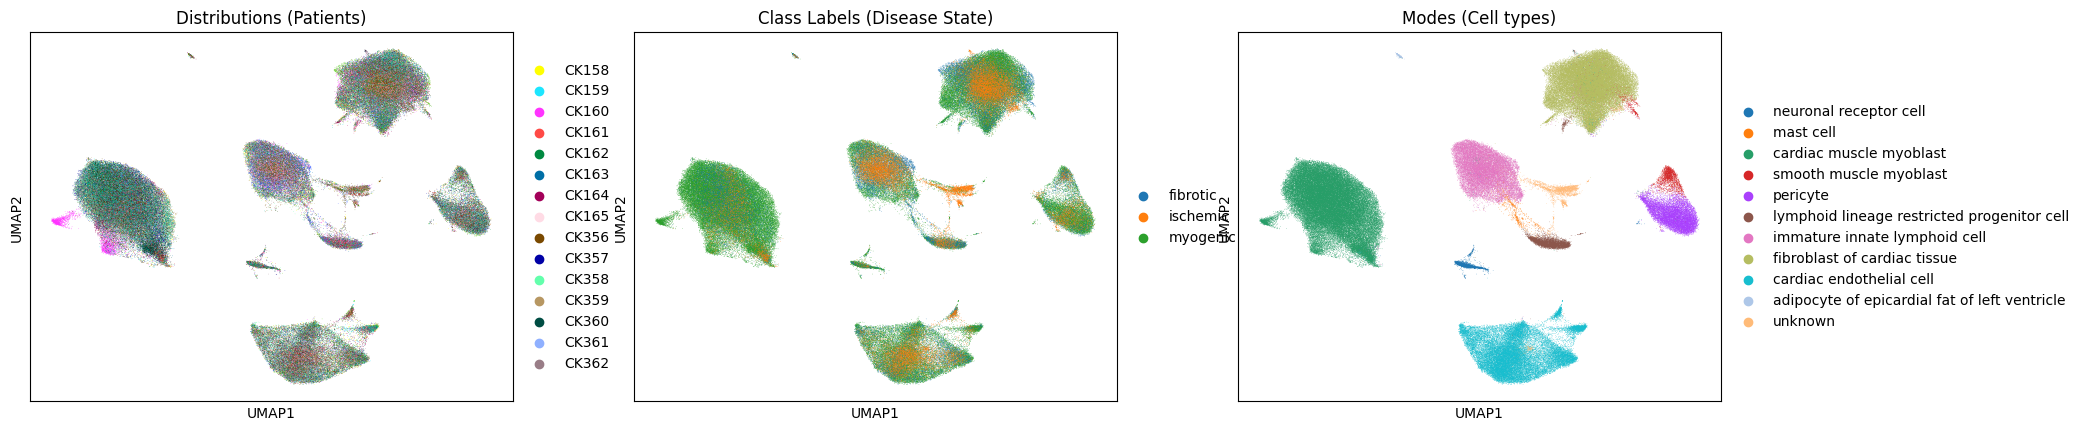

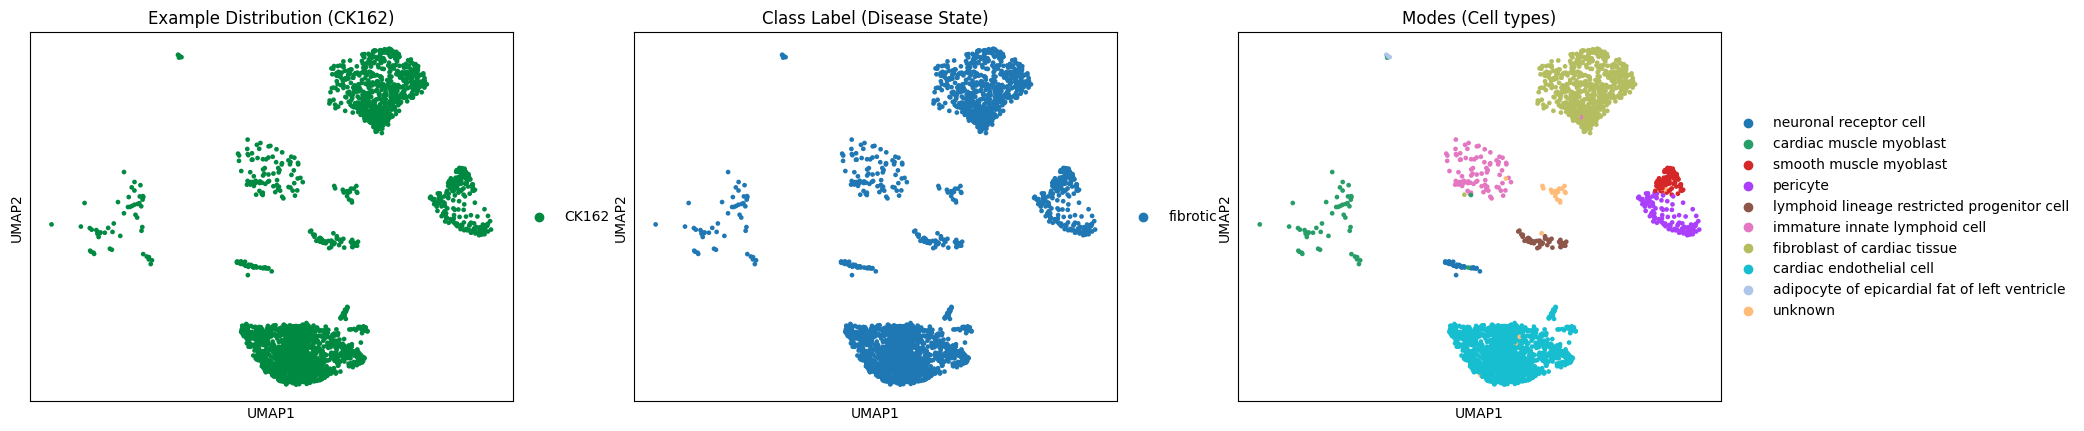

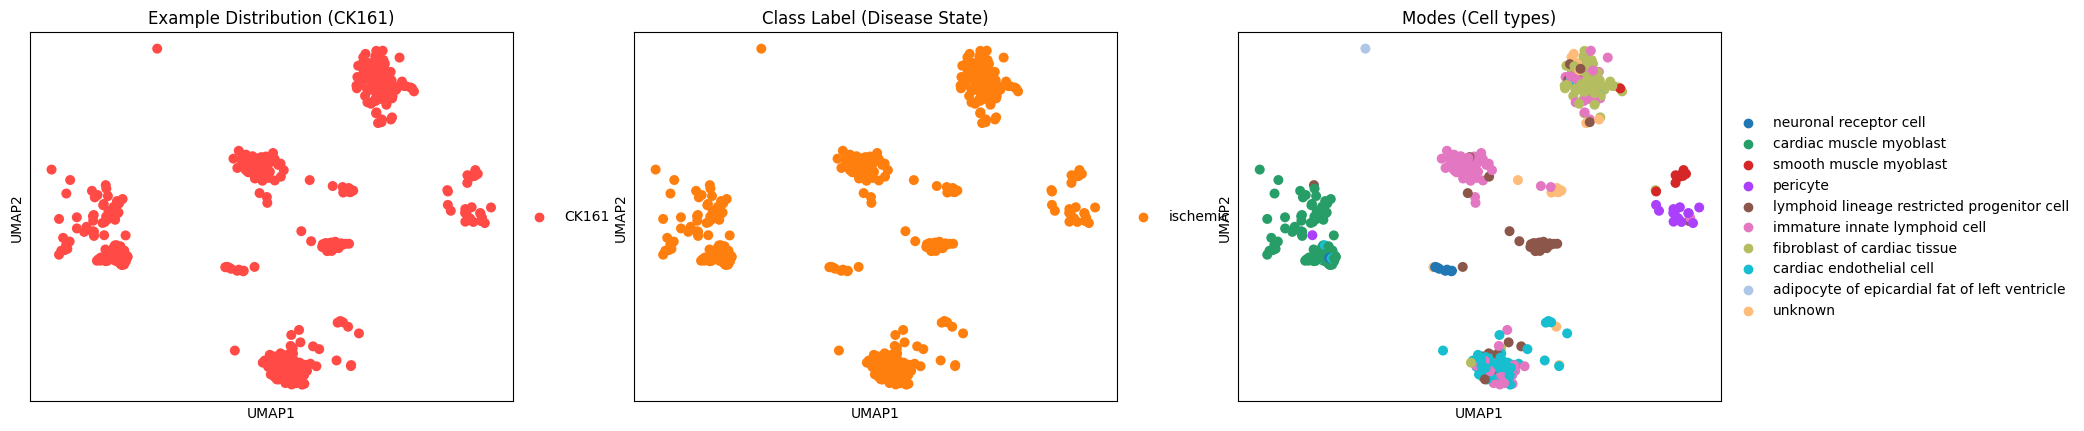

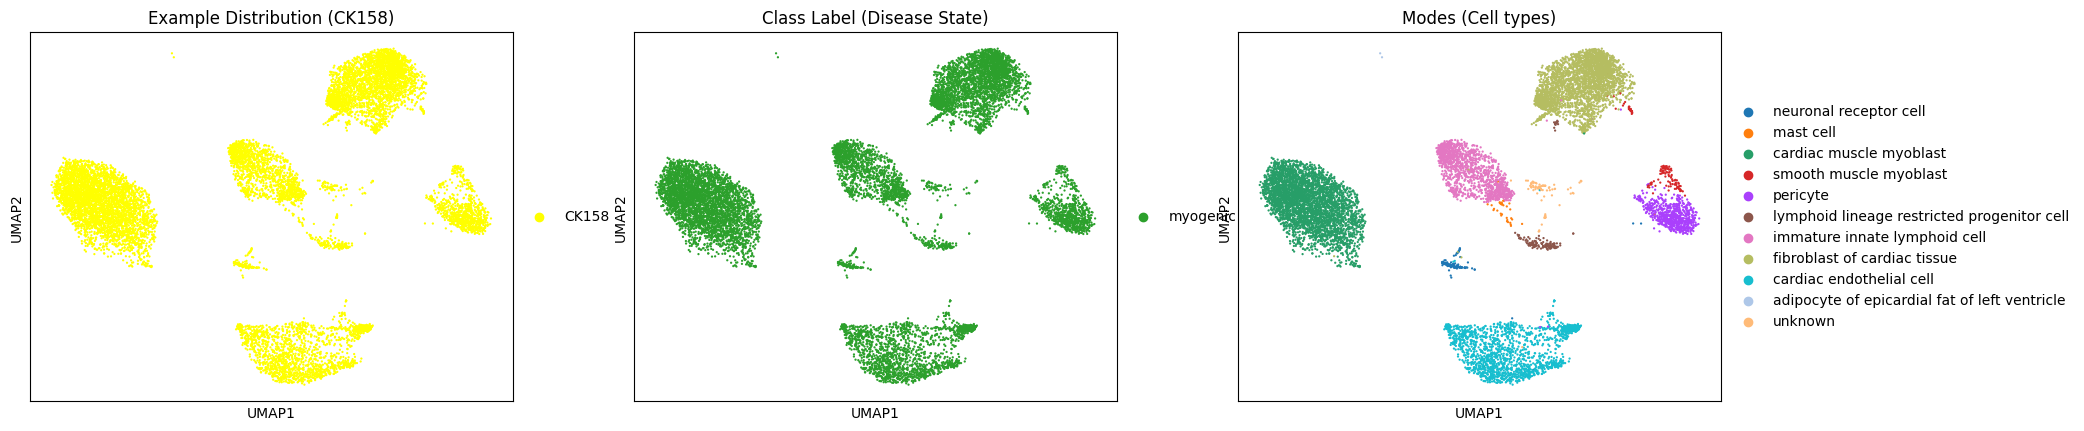

In [3]:
#Visualize complete dataset
patient_col="sample"
label_col="patient_group"
celltype_col="cell_type"
sc.pl.umap(adata,color=[patient_col,label_col,celltype_col],title=["Distributions (Patients)", "Class Labels (Disease State)", "Modes (Cell types)"])

#Visualize example patient from each disease class
for label in np.unique(adata.obs[label_col]):
    example_patient = np.unique(adata[adata.obs[label_col]==label].obs[patient_col])[0]
    sc.pl.umap(adata[adata.obs[patient_col]==example_patient],color=[patient_col,label_col,celltype_col],title=[f"Example Distribution ({example_patient})", "Class Label (Disease State)", "Modes (Cell types)"])

#### Format Anndata as pytorch dataset with triplets of patient-specific distributions of single-cells

keeping 7777 high variable genes


/home/kuehn/Heart/ggml-ot/examples/../src/ggml_ot/data/scRNA.py:261: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["use_rep_GGML"] = use_rep


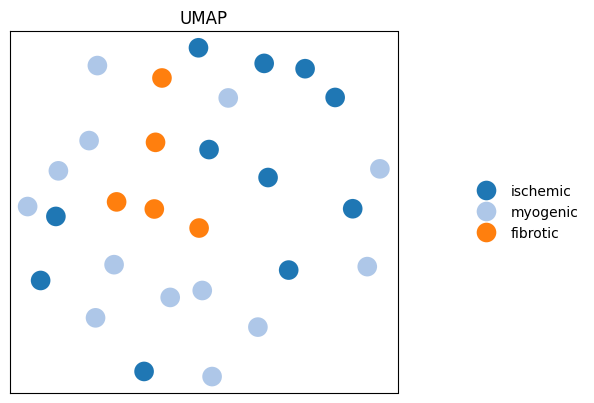

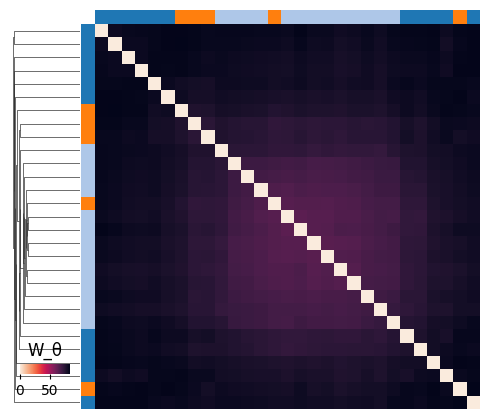

In [4]:
n_cells = 250 #here we sample only few cells to speed up the computations in the tutorial
n_threads = 64 

#Show baseline of using Optimal Transport with a fixed ground metric like the euclidean, this can be very slow for large number of cells or genes
full_dataset = ggml_ot.scRNA_Dataset(adata, n_cells = n_cells, patient_col=patient_col, label_col=label_col) 
_ = full_dataset.compute_OT_on_dists(ground_metric="euclidean")

keeping 7777 high variable genes


/home/kuehn/Heart/ggml-ot/examples/../src/ggml_ot/data/scRNA.py:261: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["use_rep_GGML"] = use_rep


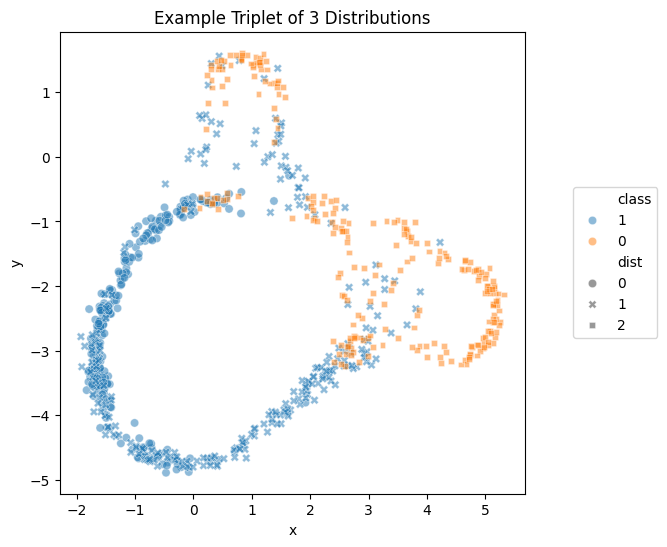

In [5]:
#Use provided interface from Anndata to Pytorch Dataset for Triplet Learning
train_dataset = ggml_ot.scRNA_Dataset(adata, n_cells = n_cells, patient_col=patient_col, label_col=label_col, subsample_patient_ratio=0.75, t = 3)

#Plot example triplet of distributions (i,j,k), capturing relative relationships of W(i,j)< W(j,k) + alpha for c_i = c_j and c_j != c_k
example_triplets, _ , example_labels = next(iter(train_dataset))
ggml_ot.plot_distribution(example_triplets, example_labels, title="Example Triplet of 3 Distributions") #TODO use PCs from full anndata to project

#### Train GGML on prepared pytorch dataset containing triplets of relative relationships

Running GGML with alpha: 10, lambda: 1, rank: 5


100%|██████████| 3/3 [01:38<00:00, 32.70s/it]


Iteration 1 with Loss  344.36065673828125


100%|██████████| 3/3 [01:50<00:00, 36.76s/it]


Iteration 2 with Loss  316.564453125


100%|██████████| 3/3 [01:33<00:00, 31.21s/it]


Iteration 3 with Loss  288.66180419921875


100%|██████████| 3/3 [01:49<00:00, 36.52s/it]


Iteration 4 with Loss  261.86932373046875


100%|██████████| 3/3 [01:47<00:00, 35.81s/it]


Iteration 5 with Loss  234.14930725097656
Compute all OT distances after 5 iterations


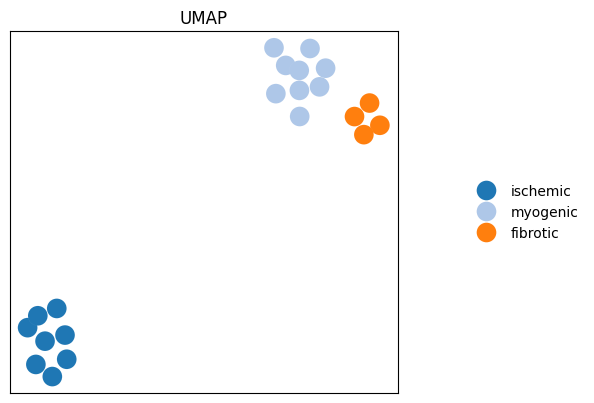

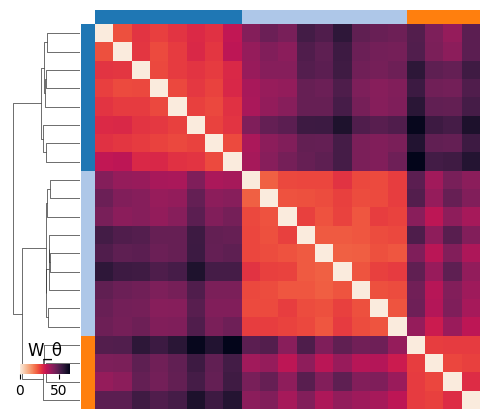

In [6]:
#Train ground metric with GGML (here on "X_pca" for speed-up, set use_rep=None in the dataset to learn subspaces of the full gene space)
trained_adata = ggml_ot.ggml(
    train_dataset, a=10, l=1, k=5, loss="cos", max_iterations=5, plot_i_iterations=5, n_threads= n_threads, adata=adata,
)

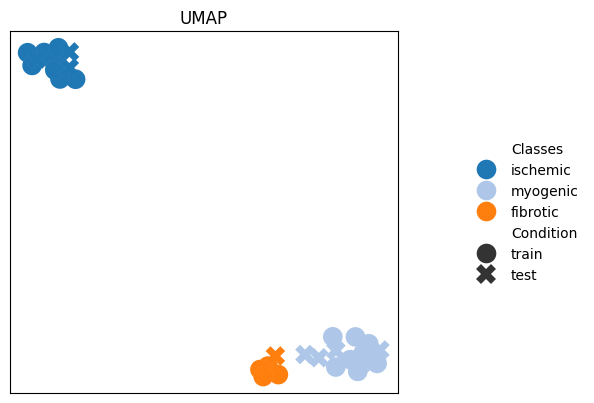

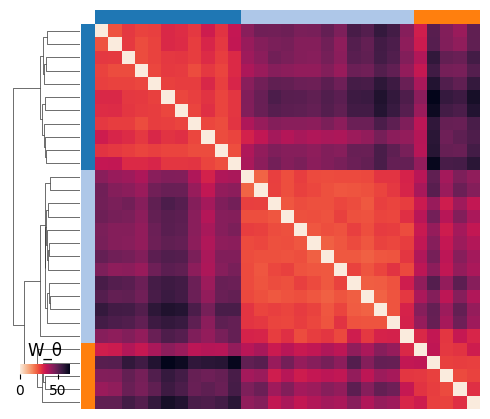

In [8]:
#Test trained weights on full dataset
train_symbols = ["train" if p in train_dataset.patient_labels else "test" for p in full_dataset.patient_labels] 
_ = full_dataset.compute_OT_on_dists(w=trained_adata.uns["W_ggml"], plot=True,symbols=train_symbols,n_threads=n_threads)

Component 0


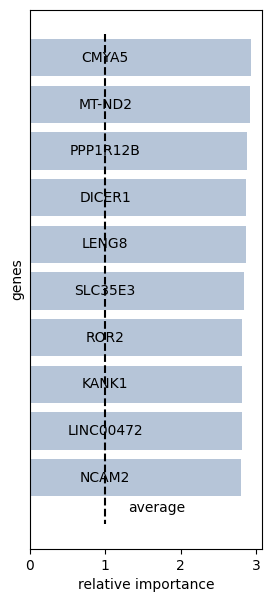

Component 1


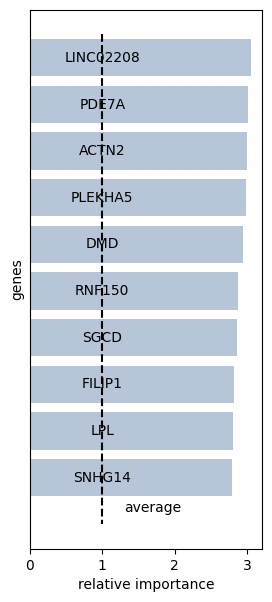

Component 2


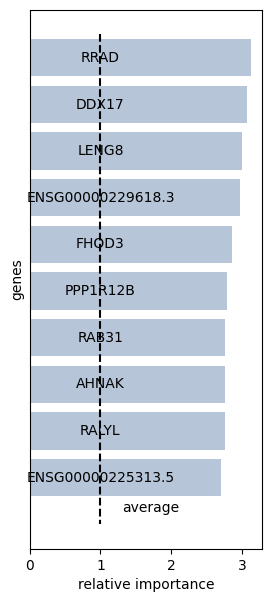

Component 3


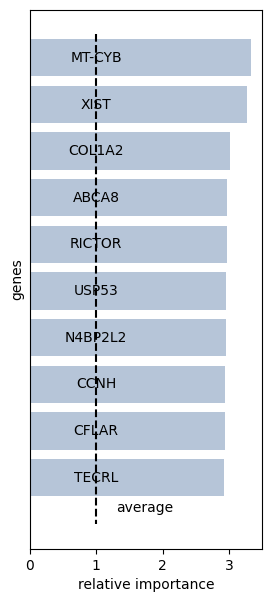

Component 4


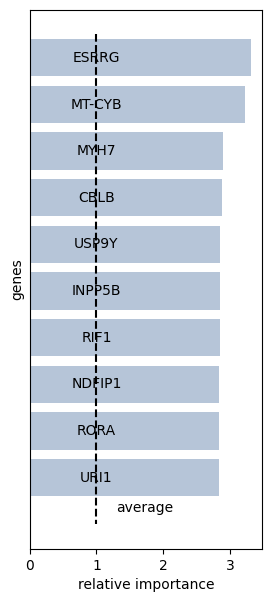

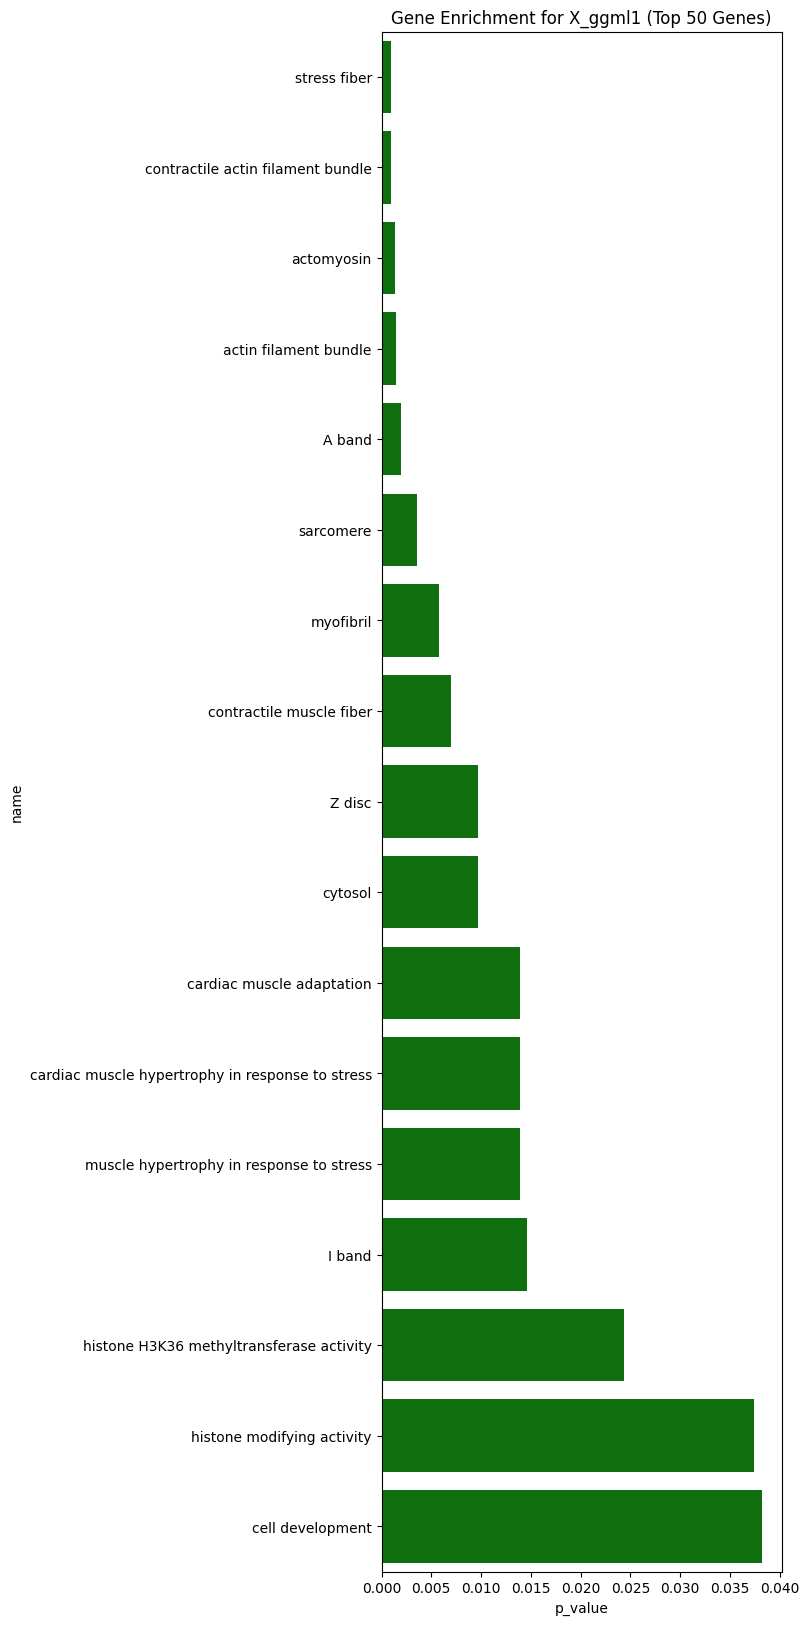

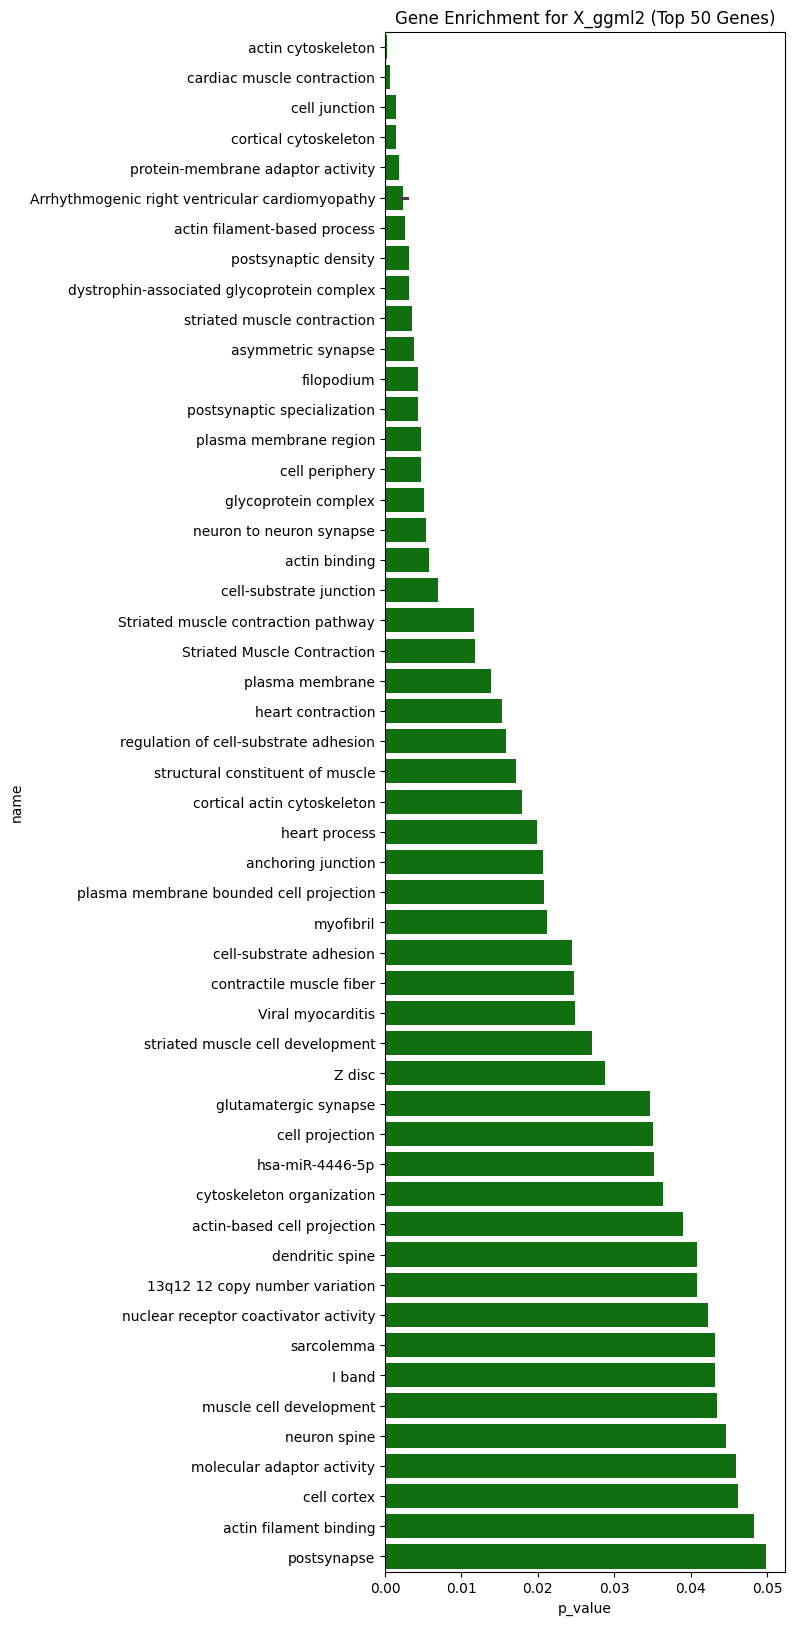

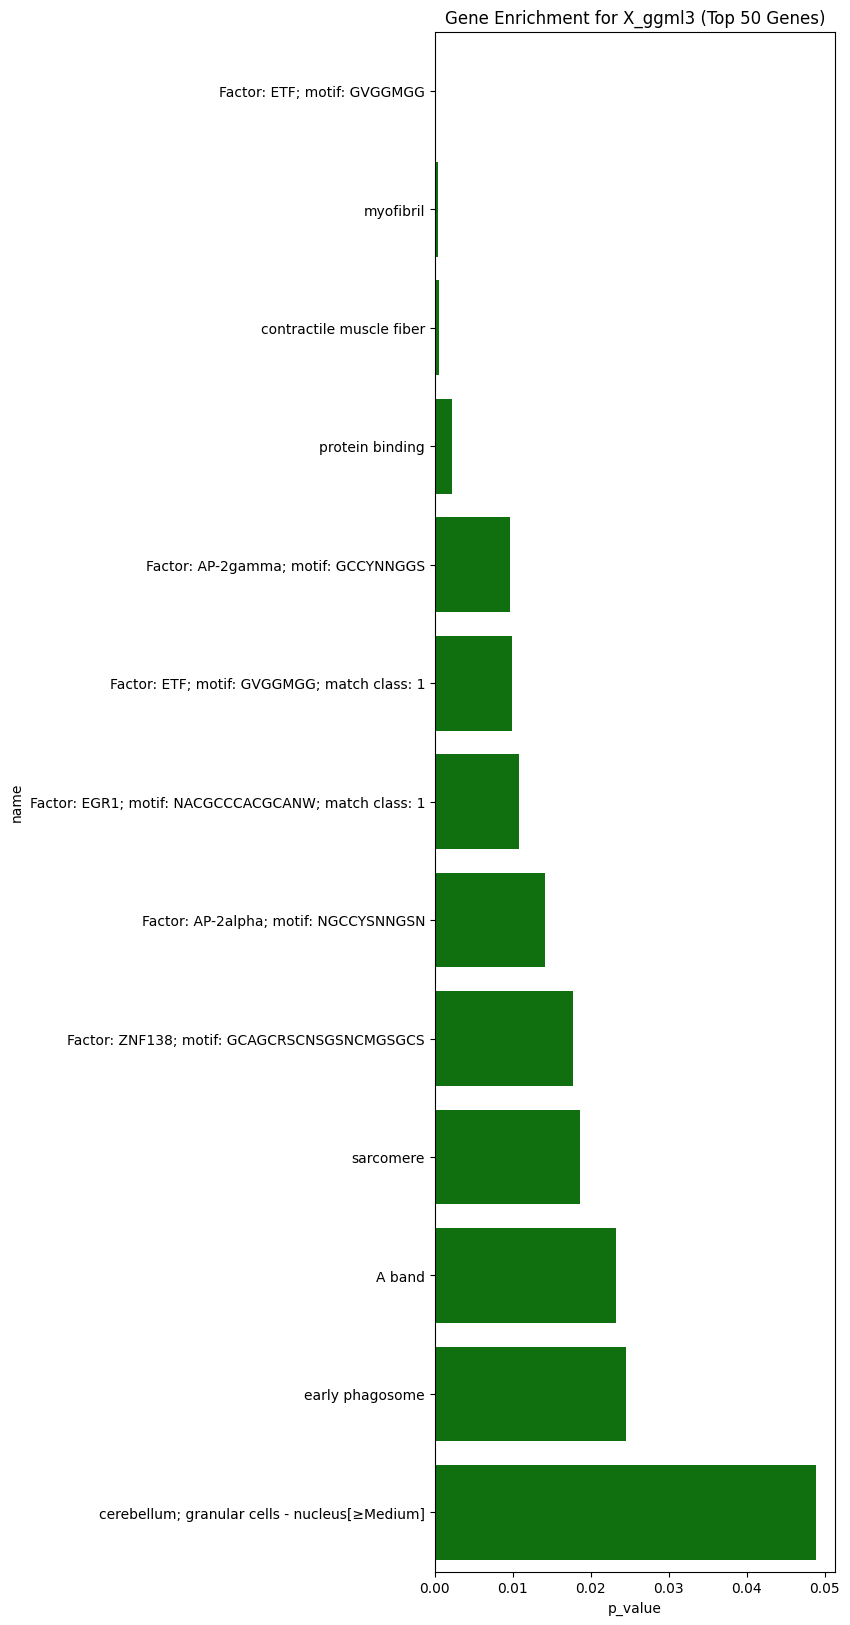

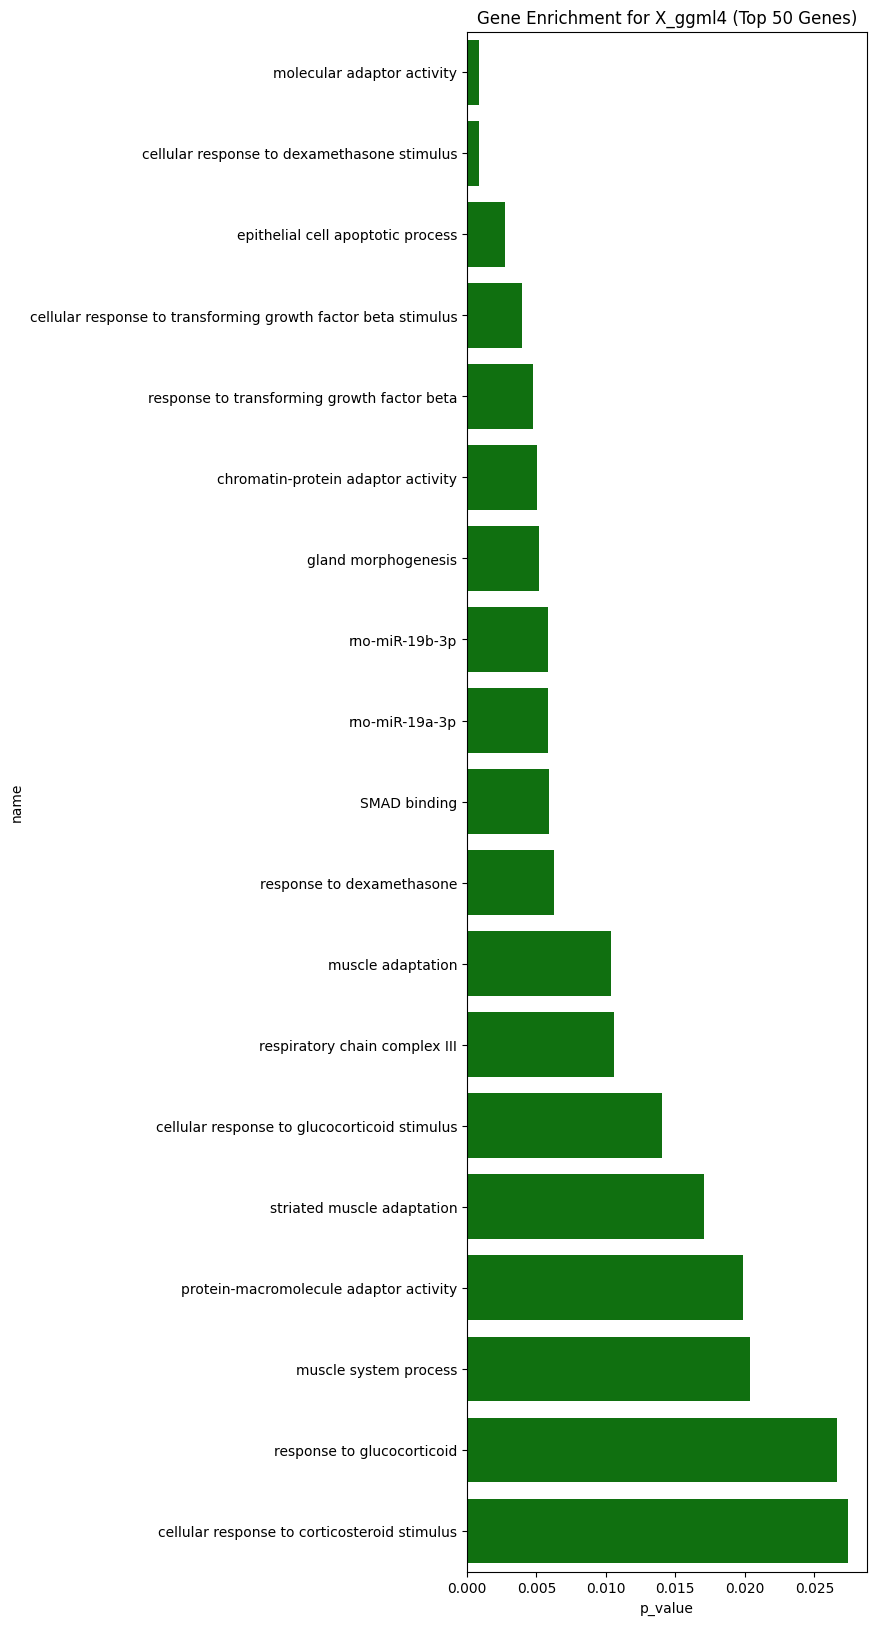

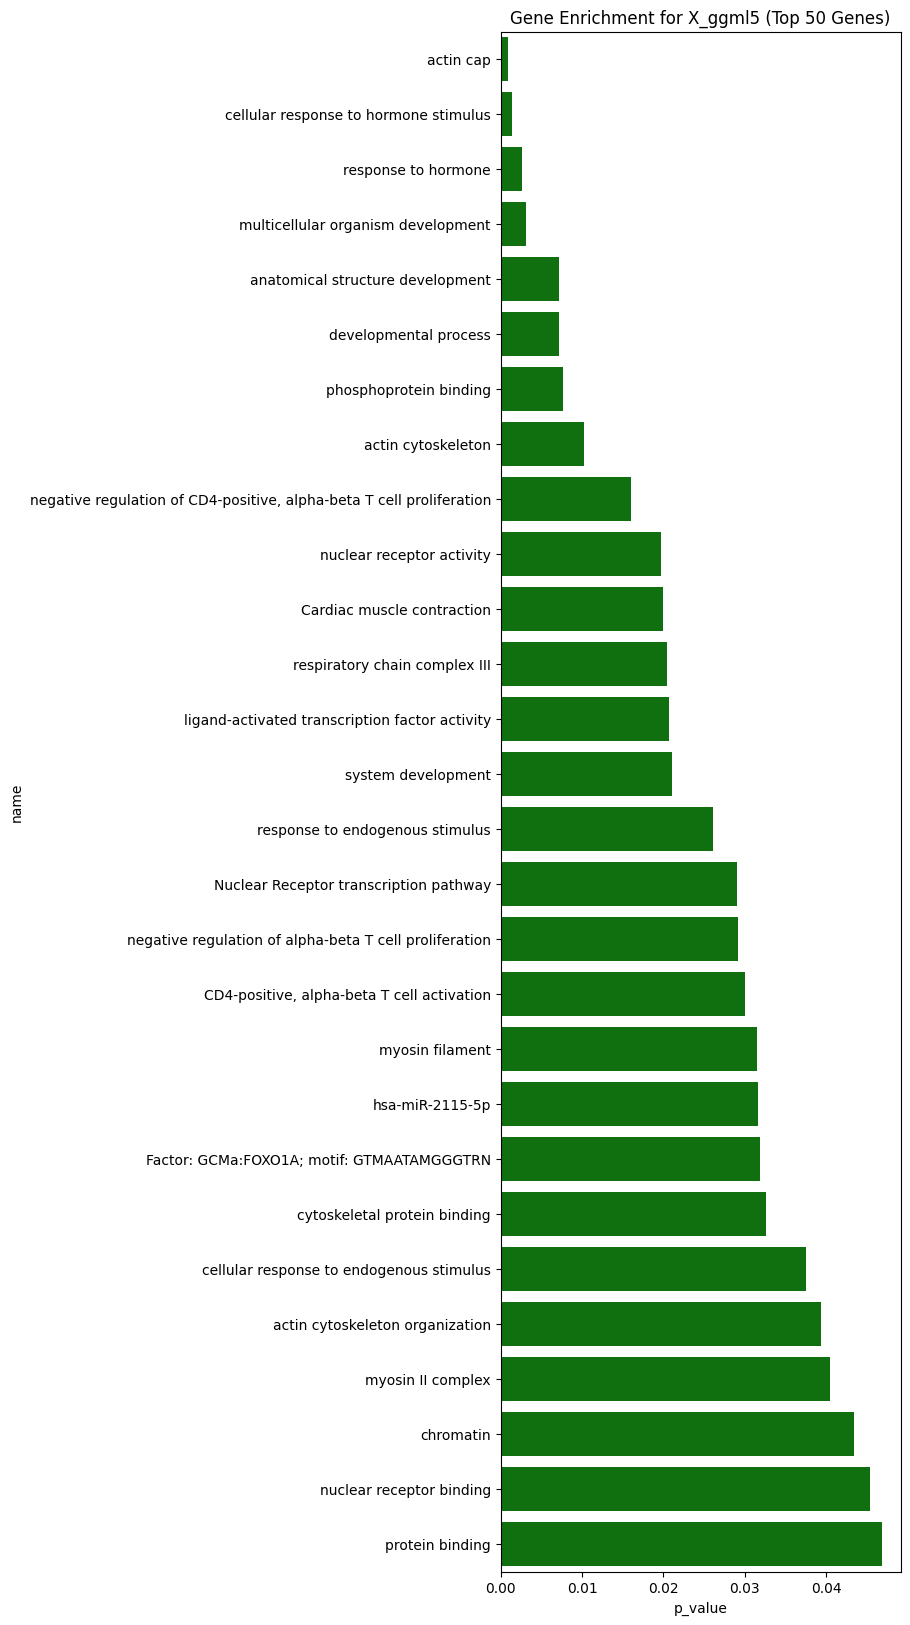

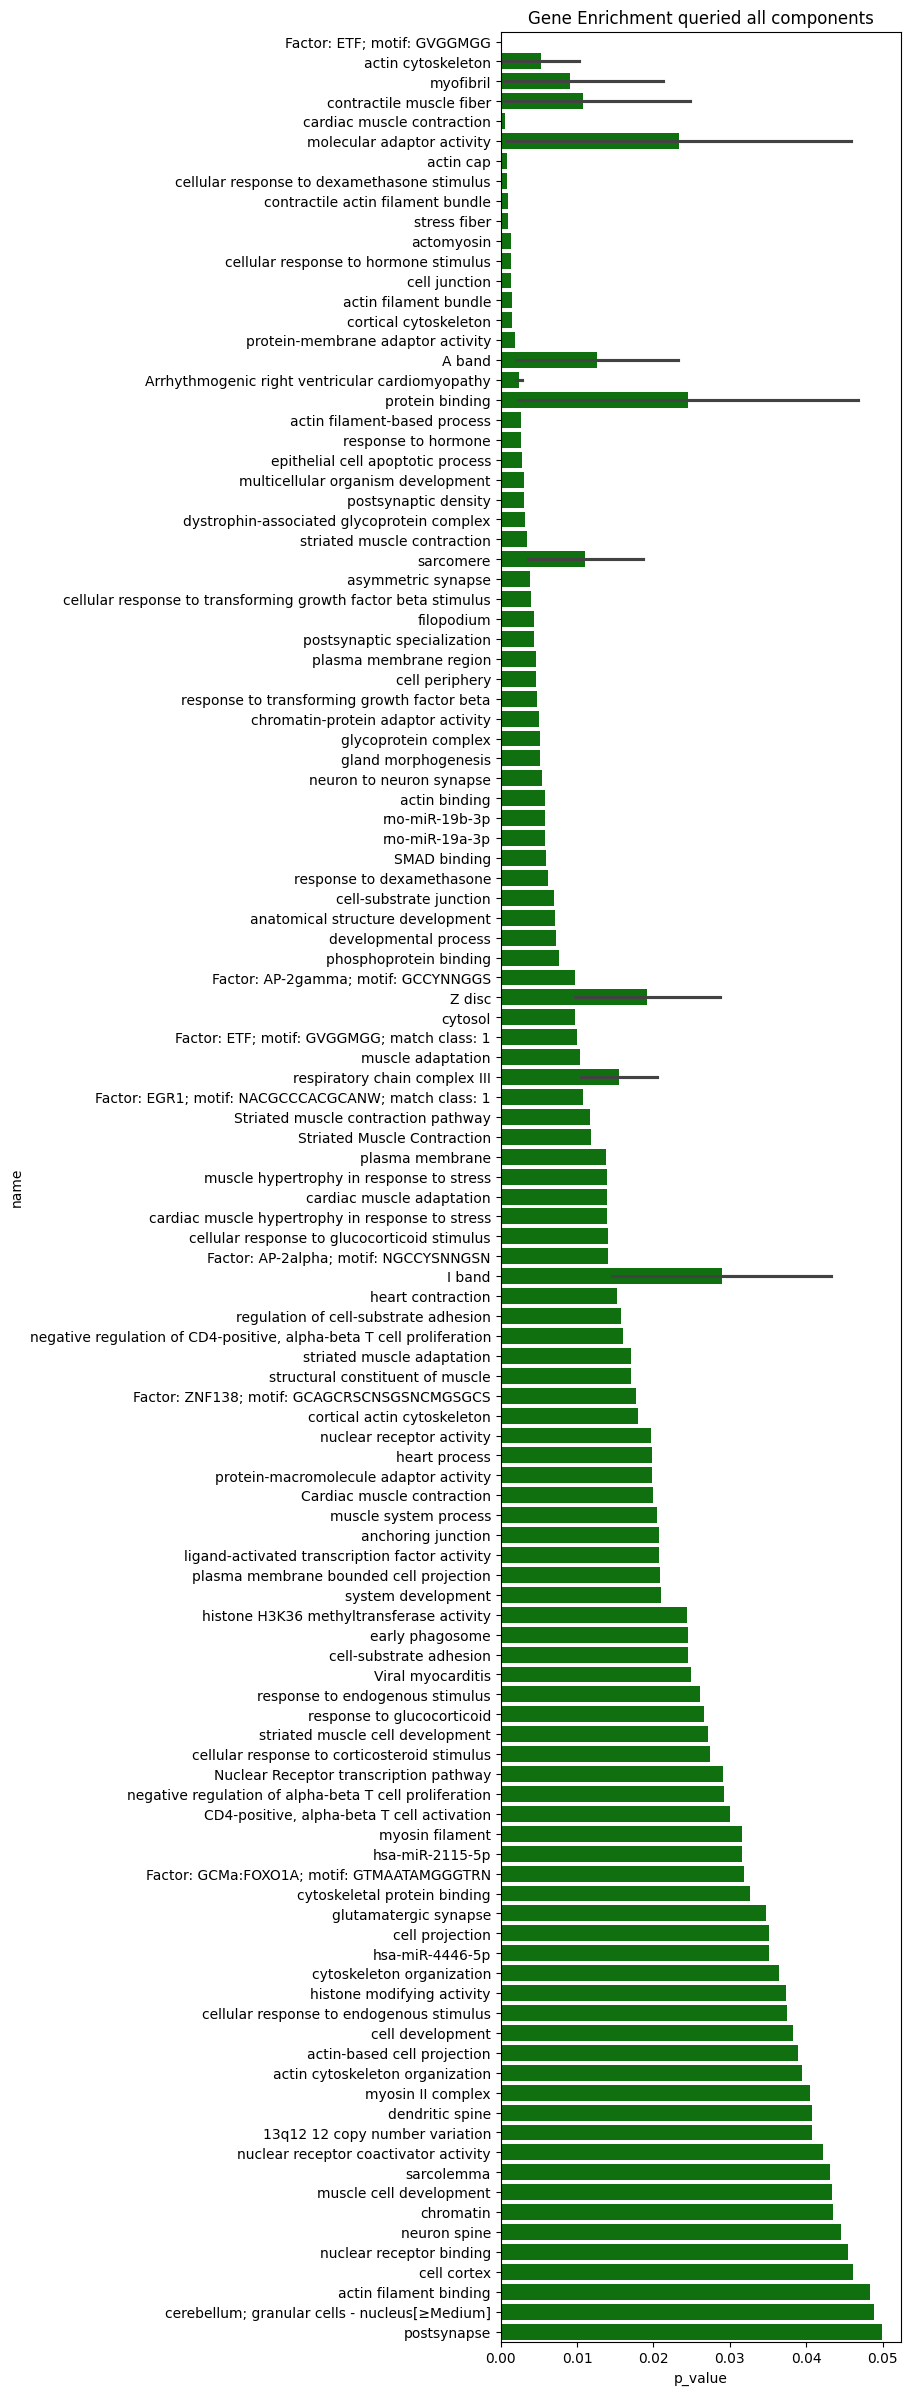

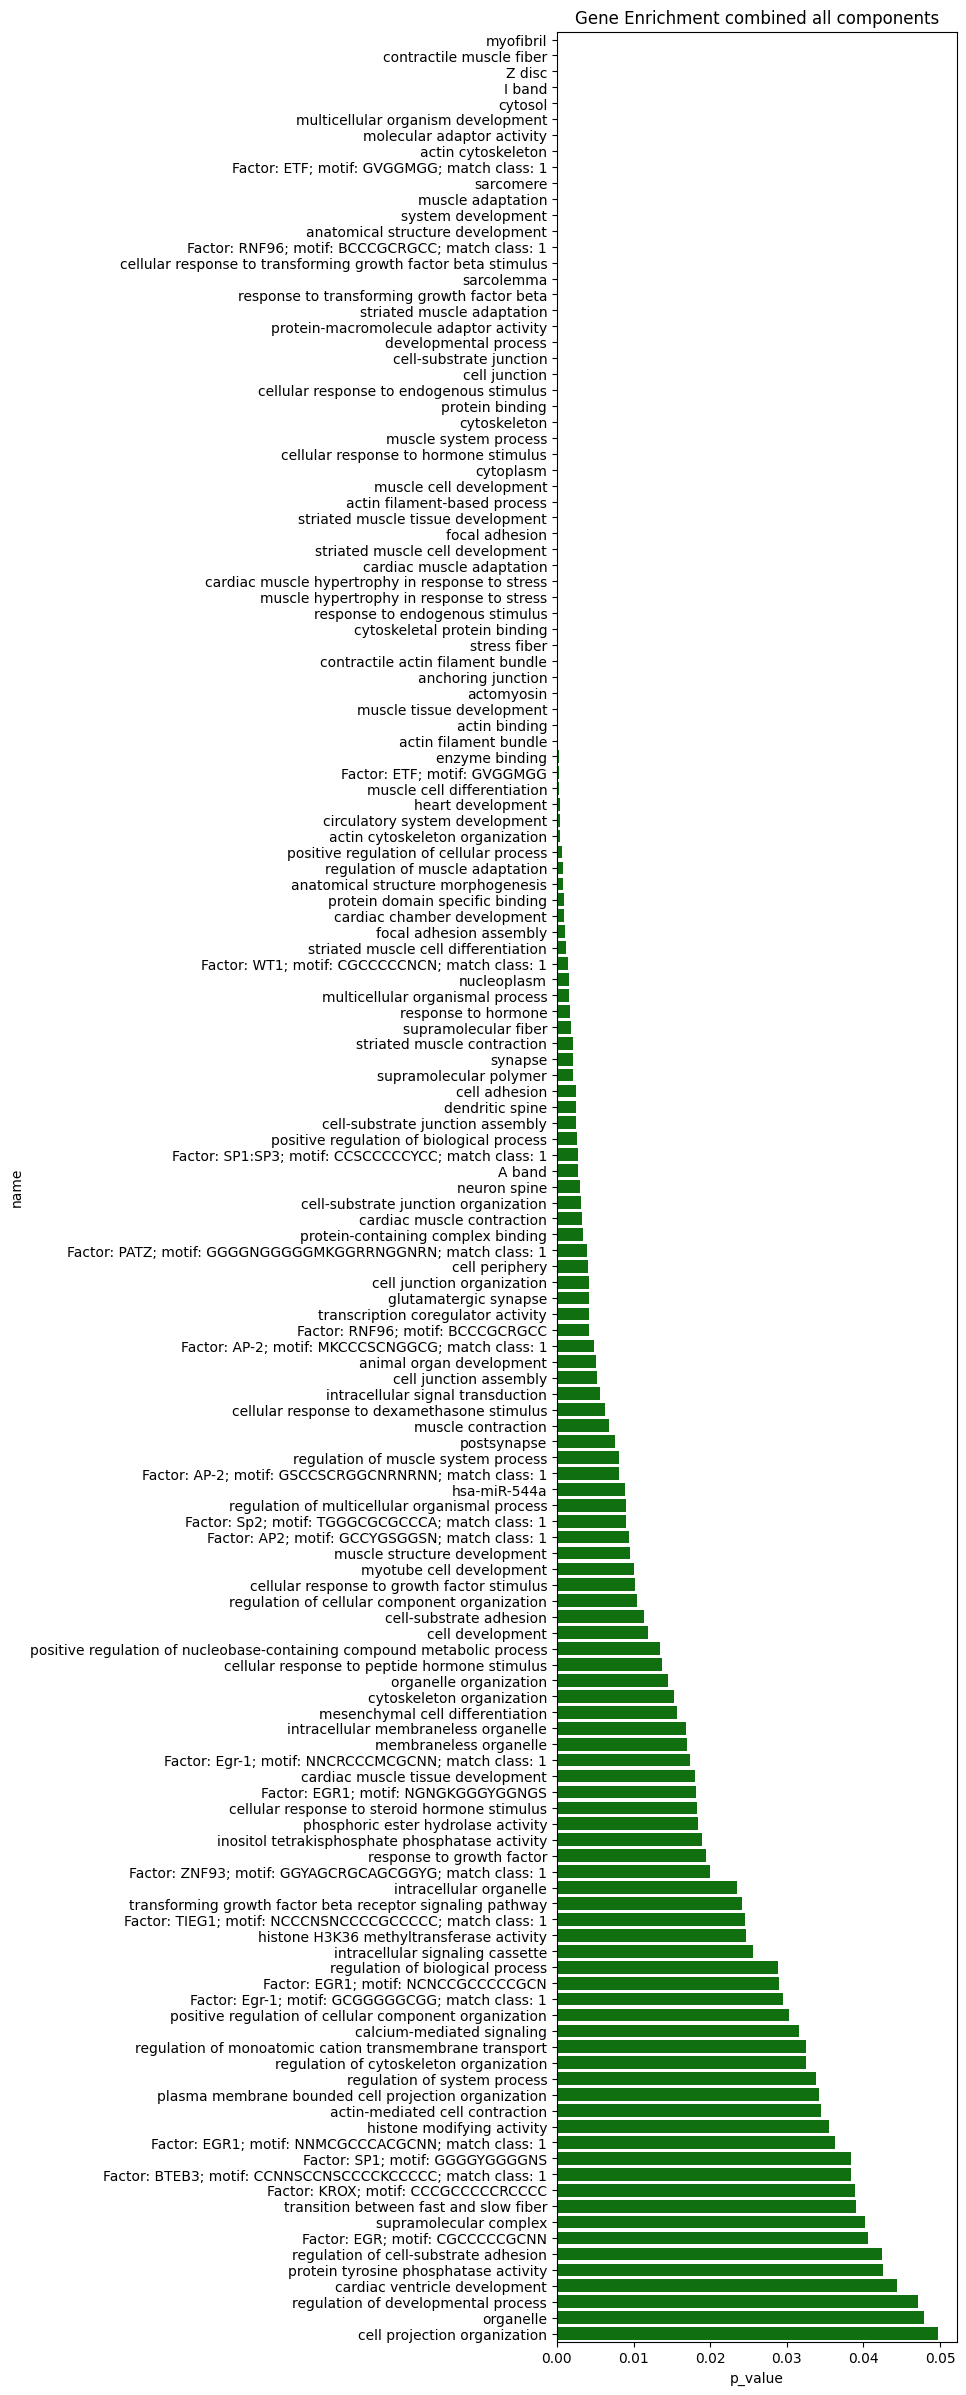

In [9]:
#Interpretability of axes of learned gene subspace
import ggml_ot.genes

_ = ggml_ot.genes.importance(trained_adata,n_top_genes=10)

top_genes = ggml_ot.genes.importance(trained_adata,n_top_genes=50,plot=False)
ggml_ot.genes.enrichment(top_genes)

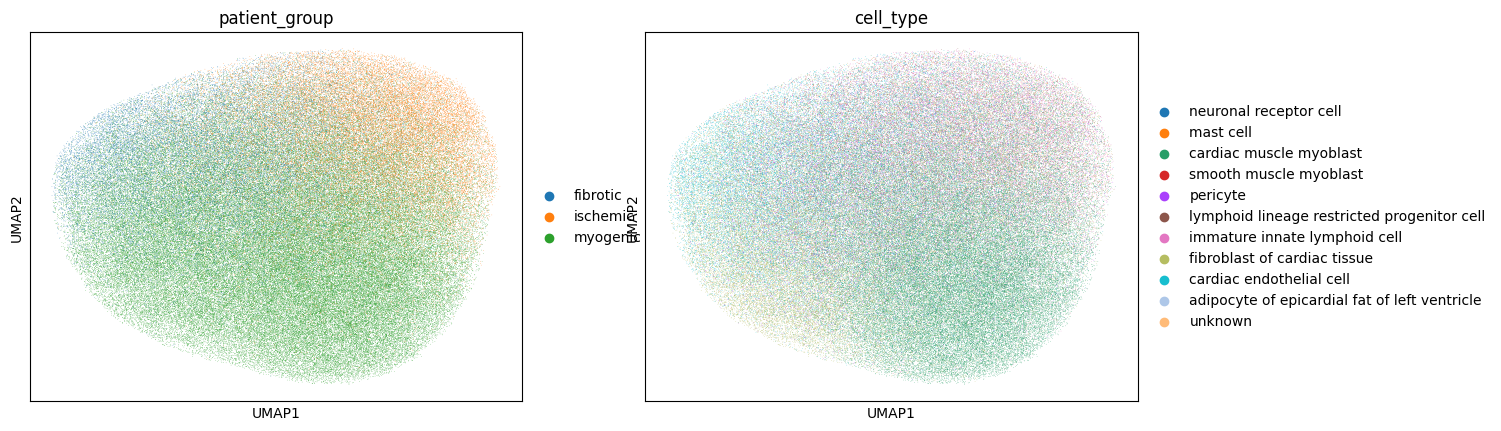

In [13]:
#Plot cells in learned subspace (use UMAP for rank > 2)
sc.pp.neighbors(trained_adata,use_rep="X_ggml") 
sc.tl.umap(trained_adata)
sc.pl.umap(trained_adata,color=[label_col,celltype_col],show=True,ncols=4)